##### Last update: april 03 2023

# Bike Share Project - Data Cleaning

In this document the data is colected, cleaned and transformed for analysis.

# Table of Contents

1. [Imports](#imports)
2. [Data Overview](#overview)
3. [Data Cleaning](#cleaning)
    * [Column re-naming](#renaming)
    * [Missing Data](#missing)
    * [Data Validation](#validation)
4. [Feature Engineering](#feature)
    * [Date](#date)
    * [Duration](#duration)
    * [Day of Week](#dow)
    * [Distance Travelled](#distance)
    * [Speed](#speed)
5. [Outliers](#outliers)
    * [Duration, speed and distance](#dynamics)
    * [Start Station Coordinates](#start_coords)
    * [End Station Coordinates](#end_coords)
6. [Verification](#verification)

# Imports <a name="imports"></a>

The usual libraries

In [1]:
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

# Data Overview <a name="overview"></a>

The data is stored in 12 datasets, each one concerning each of the previous 12 months from the date when this study was performed (March 2023). These contain in combination information for almost 6 million bike rides made between March 01 2022 and February 28 2023, which can be found [here](https://divvy-tripdata.s3.amazonaws.com/index.html). 

Every dataset has the same structure, with each row being a bike ride and having the following fields:

* **trip_id**: a unique identifier for each ride made with one of the bikes.
* **rideable_type**: the type of bike that was used. The types of bikes are electric, classic and docked.
* **started_at, ended_at**: the time and date the ride started/ended. 
* **start_station_name, end_station_name**: the name of the station where the trip started/ended.
* **start_station_id, end_station_id**: the code that identifies the station where the trip started/ended. 
* **start_lat, start_lng, end_lat, end_lng**: the coordinates for the station where the trip started/ended.
* **member_casual**: the type of user, casual or member.

To simplify the cleaning process, all 12 datasets are merged into a single, large dataframe. 

In [2]:
import glob

# collect all file names
csv_files = glob.glob("../data/*.csv")

# read each of them into a pd.DataFrame and put them into a list
df_list = [pd.read_csv(file) for file in csv_files]

# concatenate all dataframes, to get a single, large
# dataframe with all year's data
all_data = pd.concat(df_list, ignore_index=True)

And a copy of it is made to avoid having to load and merge all files again if something happens.

In [3]:
rides = all_data.copy()

`rides` is our complete datafrme. The following shows the structure of the data.

In [4]:
rides.sample(3)

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
2614086,7E945AF963EDCC51,electric_bike,2022-07-21 10:07:42,2022-07-21 10:25:37,Franklin St & Illinois St,RN-,Greenview Ave & Diversey Pkwy,13294,41.890993,-87.635356,41.932590,-87.665936,member
3059389,E3BE90D33DD39FC7,electric_bike,2022-08-20 14:24:58,2022-08-20 14:32:33,Sheffield Ave & Wrightwood Ave,TA1309000023,Lakeview Ave & Fullerton Pkwy,TA1309000019,41.928588,-87.653790,41.925858,-87.638973,member
1448299,BD7DEE072662E137,electric_bike,2022-06-17 08:55:30,2022-06-17 09:05:17,Honore St & Division St,TA1305000034,Western Ave & Winnebago Ave,13068,41.903161,-87.673912,41.915520,-87.687022,casual


As mentioned above, there are almost 6 million rows of data, with 13 columns containing information about the type of bike and user as well as the time and location where each trip started and ended. As can be seen below, there are some errors regarding the data types. Specifically, the dates and times are stored as string type.

In [5]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5829084 entries, 0 to 5829083
Data columns (total 13 columns):
 #   Column              Dtype  
---  ------              -----  
 0   ride_id             object 
 1   rideable_type       object 
 2   started_at          object 
 3   ended_at            object 
 4   start_station_name  object 
 5   start_station_id    object 
 6   end_station_name    object 
 7   end_station_id      object 
 8   start_lat           float64
 9   start_lng           float64
 10  end_lat             float64
 11  end_lng             float64
 12  member_casual       object 
dtypes: float64(4), object(9)
memory usage: 578.1+ MB


The only numeric fields are those for the coordinates, for which the statistical summaries are not too useful. It is worth noting, though, that there are some inconsistencies within the end station coordinates, showing latitudes and longitudes going all the way to 0°. If this was correct then there would have been bikes stationed within an area of almost 1/16th of the surface of the Earth. Who would have thought Chicago was so big?

In [6]:
rides.describe()

,start_lat,start_lng,end_lat,end_lng
count,5.829084e+06,5.829084e+06,5.823146e+06,5.823146e+06
mean,4.190217e+01,-8.764779e+01,4.190237e+01,-8.764786e+01
std,4.626503e-02,2.927663e-02,6.757085e-02,1.068591e-01
min,4.164000e+01,-8.784000e+01,0.000000e+00,-8.814000e+01
25%,4.188103e+01,-8.766150e+01,4.188103e+01,-8.766201e+01
50%,4.190000e+01,-8.764411e+01,4.190000e+01,-8.764414e+01
75%,4.193000e+01,-8.762963e+01,4.193000e+01,-8.762963e+01
max,4.207000e+01,-8.752000e+01,4.237000e+01,0.000000e+00


Finaly, the result below shows the number of duplicated rows. We can see there aren't any: each row has an unique ride id, which means it is a unique bike trip.

In [7]:
rides.duplicated(subset=["ride_id"]).sum()

0

# Data Cleaning <a name="cleaning"></a>

## Column re-naming <a name="renaming"></a>

The column names can be changed into shorter and more intuitive ones

In [8]:
rides.rename(
    columns={
        "ride_id": "trip_id",
        "rideable_type": "bike_type",
        "started_at": "start_time",
        "ended_at": "end_time",
        "start_station_name": "start_name",
        "start_station_id": "start_id",
        "end_station_name": "end_name",
        "end_station_id": "end_id",
        "member_casual": "usertype",
    },
    inplace=True,
)

## Missing Data <a name="missing"></a>

There are values missing from some fields. The following table represents what percentage of data is missing from each field. 
There is a considerable proportion of start/end station names and id's missing and only a small amount of latitud/longitude data missing.

In [9]:
# isna returns a df of the same shape as rides with boolean values for
# whether the values are NA. The mean for each column is the proportion
# of missing data for the column, and multiplied by 100 gives the %.

rides.isna().mean().mul(100).rename("% of missing data").rename_axis("Field").to_frame()

,% of missing data
Field,
trip_id,0.000000
bike_type,0.000000
start_time,0.000000
end_time,0.000000
start_name,14.589222
start_id,14.591486
end_name,15.594869
end_id,15.597288
start_lat,0.000000


The missing station names and id's can be explained with the fact that e-bikes don't need to be docked at stations, they can be locked at public bike racks, light poles, signposts, etc. 
The following table shows the number of rows with missing station names or ids by bike type, and confirms this is the case for most of the rides with missing names and id's. 

In [10]:
# create a filter for the relevant fields
cols = ["bike_type", "start_name", "start_id", "end_name", "end_id"]

# filter the data and group by bike type
missing = rides[cols].groupby("bike_type")

# count the number of rows with missing values and format table
missing.apply(lambda x: x.isnull().any(axis=1).sum()).rename(
    "Rows with missing values"
).to_frame()

,Rows with missing values
bike_type,
classic_bike,3521
docked_bike,2681
electric_bike,1324984


There are a few trips that were made with classic and docked bikes that started or ended at no specified station. We can safely discard those since they account for a really small percentage of the total trips (0.11%). As for the trips made with e-bikes that were parked at no specific station, we can state they were parked at "No station", with id "99999".

In [11]:
# create a filter for electric bikes
mask = rides["bike_type"] == "electric_bike"

# change stations missing names to "No stations"
for col in ["start_name", "end_name"]:
    rides.loc[mask & (rides[col].isna()), col] = "No station"

# change stations missing ids to "99999"
for col in ["start_id", "end_id"]:
    rides.loc[mask & (rides[col].isna()), col] = "99999"

This reduces the rows with missing data to the following

In [12]:
print("% of missing data: ", rides.isnull().any(axis=1).sum() / len(rides) * 100)

% of missing data:  0.10639750602324481


This is such a small percentage of the data that it can be safely removed, after which we are left with 0 missing values:

In [13]:
rides_complete = rides.dropna().copy()
print("Num. of missing values:", rides_complete.isnull().sum().sum())

Num. of missing values: 0


## Data Validation <a name="validation"></a>

In this section we take a closer look at the data and fix problems regarding the accuracy, consistency, completeness and formatting of the data.

### Names and IDs

There are supposed to be around 600 stations in total, 3 types of bikes (docked, classic and e-bikes) and 2 types of users (casual and members). The following table shows that, according to the data, this is not the case for the station names and ids. Even the ratio of station names to ids, which should always be one to one, is inconsistent. There are also some issues with the coordinates, but those will be addressed later on.

In [14]:
rides_complete[
    ["bike_type", "usertype", "start_name", "start_id", "end_name", "end_id"]
].nunique().rename("Num. of unique values").to_frame()

,Num. of unique values
bike_type,3
usertype,2
start_name,1693
start_id,1315
end_name,1716
end_id,1319


As seen above, there are a lot more stations names and id's than should be. Some tests for the consistency of station names and ids are then needed; The following function will test if a name or id relates to multiple id's or names. It is performed only on a sample of the data since it is very time consuming to run it on larger scale.

In [15]:
def not_unique(field1, field2, frac):
    """This function takes in 2 column names, field1 and field2, as well
    as the fraction, frac, of the dataframe that will be processed, and 
    returns a dictionary with the field1 values that refer to multiple
    unique values for field2, as well as the corresponding list of field2
    values."""

    id_names = {}

    # Get a random subset of the dataframe to process based on the given fraction
    subset = rides_complete.sample(frac=frac, random_state=25)

    # Find field1 values that map to multiple unique field2 values
    condition = subset.groupby(field1)[field2].nunique() > 1
    keys = subset.groupby(field1)[field1].unique()[condition]
    keys = [elem.tolist()[0] for elem in keys.values]  # convert to list

    # fill in the dictionary
    for key in keys:
        id_names[key] = [*subset[subset[field1] == key][field2].unique()]

    return id_names

The next two blocks of code show the number of id's that refer to two or more station names within a sample of 10% of the data, as well as the names of the stations for each of these id's.

In [16]:
repeated_ids = not_unique("start_id", "start_name", 0.1)
len(repeated_ids)

175

In [17]:
repeated_ids

{'13053': ['Green St & Randolph St', 'Green St & Washington Blvd'],
 '13059': ['Sheridan Rd & Argyle St', 'Bissell St & Armitage Ave'],
 '13074': ['Broadway & Wilson - Truman College Vaccination Site',
  'Broadway & Wilson Ave'],
 '13197': ['Elizabeth (May) St & Fulton St', 'Elizabeth St & Fulton St'],
 '15541': ['Buckingham Fountain', 'Buckingham Fountain (Temp)'],
 '15623': ['Campbell Ave & Montrose Ave',
  'Campbell Ave & Montrose Ave (Temp)'],
 '303': ['Public Rack - Kildare Ave & Division St',
  'Kildare Ave & Division St'],
 '390': ['California Ave & Marquette Rd',
  'Public Rack - California Ave & Marquette Rd'],
 '479': ['California Ave & Touhy Ave - NW',
  'Public Rack - California Ave & Touhy Ave - NW'],
 '480': ['Public Rack - Rockwell Ave & Touhy Ave ',
  'Rockwell Ave & Touhy Ave '],
 '482': ['Public Rack - Chase Ave & Touhy Ave - NE',
  'Chase Ave & Touhy Ave - NE'],
 '483': ['Public Rack - Western Ave & Jarvis Ave', 'Western Ave & Jarvis Ave'],
 '484': ['Public Rack - Sa

Many id's do refer to different station names, but many of them have a version with "Public Rack - " or with " (Temp)" in the name and a version without. 

The next lines fix this so that the data is a bit more homogenous and the analisys more reliable.

In [18]:
# remove 'Public Rack - ' and ' (Temp)' from station names.

rides_complete["start_name"] = (
    rides_complete["start_name"]
    .str.replace("Public Rack - ", "")
    .str.replace(" (Temp)", "")
)

rides_complete["end_name"] = (
    rides_complete["end_name"]
    .str.replace("Public Rack - ", "")
    .str.replace(" (Temp)", "")
)

C:\Users\Juan\AppData\Local\Temp/ipykernel_5756/1033773167.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  rides_complete["start_name"]
C:\Users\Juan\AppData\Local\Temp/ipykernel_5756/1033773167.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  rides_complete["end_name"]


And Lets see how many station names we are left with.

In [19]:
rides_complete[["start_name", "start_id", "end_name", "end_id"]].nunique().rename(
    "Num. of unique values"
).to_frame()

,Num. of unique values
start_name,1407
start_id,1315
end_name,1407
end_id,1319


Its a little bit better, there still are a lot more station names and ids than there should be, but at least the mapping is closer to being 1 to 1. The following does the same but the other way around: shows station names that point to multiple id's.

In [20]:
repeated_names = not_unique("start_name", "start_id", 0.2)
len(repeated_names)

21

In [21]:
repeated_names

{'Ashland Ave & 63rd St': ['16948', '996'],
 'California Ave & Cortez St': ['17660', '512'],
 'Calumet Ave & 51st St': ['15470', '813'],
 'Central Park Ave & Ogden Ave': ['15685', '532'],
 'Christiana Ave & Lawrence Ave': ['860', '15615'],
 'Clyde Ave & 87th St': ['20230', '986'],
 'East End Ave & 87th St': ['20231', '883'],
 'Eberhart Ave & 61st St': ['KA1503000033', '955'],
 'Eggleston Ave & 92nd St': ['20118', '707'],
 'Ewing Ave & 106th St': ['980', '612'],
 'Halsted St & 111th St': ['20127', '875'],
 'Halsted St & 63rd St': ['745', 'KA1503000055'],
 'Jeffery Blvd & 67th St': ['KA1503000030', '753'],
 'Kedzie Ave & Chicago Ave': ['KA1504000114', '1055'],
 'Kostner Ave & Wrightwood Ave': ['321', '1018'],
 'Lake Park Ave & 47th St': ['TA1308000035', '812'],
 'Lawndale Ave & 111th St': ['20203', '893'],
 'Prairie Ave & Garfield Blvd': ['TA1307000160', '906', '954'],
 'Pulaski Rd & Lake St': ['528', '1013'],
 'South Shore Dr & 71st St': ['KA1503000002', '948'],
 'Wabash Ave & 87th St':

In [22]:
del repeated_ids, repeated_names

There are no obvious patterns here, but the good thing is that the problem is a lot less severe in this direction: there are many id's that point to multiple station names but few names pointing to multiple ids. 

Maybe an explanation for all of this is that the stations changed names/id's at some point? Let's investigate how many unique station names/id's are there per month to check this hypothesis. 

For this purpose, it will be easiest to convert the dates into datetime objects and then get the year and month, but first it is necessary to verify the date format is consistent throughout the data. The next lists show the dates that do not start with either the year 2022 or 2023. Since they are both empty it is safe to say that the format is consistent.

In [23]:
[date for date in rides_complete["start_time"] if date[:4] not in ["2022", "2023"]]

[]

In [24]:
[date for date in rides_complete["end_time"] if date[:4] not in ["2022", "2023"]]

[]

Next the dates are typecasted as datetime objects and the the year, month and time of day extracted since it might be interesting to study the hourly usage of the bikes in the analysis phase.

In [25]:
# Convert start and end times from string to datetime

rides_complete["start_time"] = pd.to_datetime(
    rides_complete["start_time"], format="%Y-%m-%d %H:%M:%S"
)

rides_complete["end_time"] = pd.to_datetime(
    rides_complete["end_time"], format="%Y-%m-%d %H:%M:%S"
)

In [26]:
# Extract year, month and time of day (hour) from the start time for the ride.

rides_complete = rides_complete.assign(year=rides_complete["start_time"].dt.year)
rides_complete = rides_complete.assign(month=rides_complete["start_time"].dt.month)
rides_complete = rides_complete.assign(time_of_day=rides_complete["start_time"].dt.hour)

And since it would be more comfortable to see the months with their names, and to keep them ordered, we can make a mapping and enforce a chronological order into it.

In [27]:
months = {
    1: "Jan",
    2: "Feb",
    3: "Mar",
    4: "Apr",
    5: "May",
    6: "Jun",
    7: "Jul",
    8: "Aug",
    9: "Sep",
    10: "Oct",
    11: "Nov",
    12: "Dec",
}

month_order = [
    "Mar",
    "Apr",
    "May",
    "Jun",
    "Jul",
    "Aug",
    "Sep",
    "Oct",
    "Nov",
    "Dec",
    "Jan",
    "Feb",
]

# imposes a categorical order to the names of each month.
rides_complete["month"] = (
    rides_complete["month"]
    .map(months)
    .astype(pd.api.types.CategoricalDtype(categories=month_order, ordered=True))
)

The following table shows how many unique station names and id's are found per month for the last 12 months.

In [28]:
rides_complete.groupby("month")[
    ["start_name", "start_id", "end_name", "end_id"]
].nunique()

,start_name,start_id,end_name,end_id
month,,,,
Mar,844,844,835,835
Apr,840,840,838,837
May,1086,1051,1092,1055
Jun,1149,1116,1162,1128
Jul,1192,1148,1204,1162
Aug,1229,1191,1217,1185
Sep,1172,1131,1177,1136
Oct,1091,1069,1099,1071
Nov,1051,1037,1059,1041


The number of stations is not accurate nor consistent on any of these fields, since the number of stations is in reality around 600, which is half to 3/4 of the monthly reported stations on the data. To homogenize things a little bit, we proceed to make the mapping of station names to id's one to one (or at least as much as possible). After some testing it was found that the most effective way of doing it is to start reducing the number of names and continue with the ids.

In [29]:
def id_name_map(df, field1, field2):
    """This function makes the relation between field1 and field2 values a surjective one. 
    This means that each field1 value will map to a single value in field2. Applying this 
    function twice, once from field1 to field2 and the sencond time from field2 to field1
    will make the mapping one to one."""

    # selects the first field2 value appearing in the data for each unique field1 value
    val_to_keep = df.groupby(field1)[field2].apply(lambda x: x.iloc[0])

    # returns the selected field2 value for each unique field 1 value.
    # after this all field1 value will point to one unique field 2 value
    return df[field1].apply(lambda x: val_to_keep[x])

In [30]:
# This makes the start stations names and ids one to one.

rides_complete["start_name"] = id_name_map(rides_complete, "start_id", "start_name")
rides_complete["start_id"] = id_name_map(rides_complete, "start_name", "start_id")

In [31]:
# and now for the end stations

rides_complete["end_name"] = id_name_map(rides_complete, "end_id", "end_name")
rides_complete["end_id"] = id_name_map(rides_complete, "end_name", "end_id")

After this we at least have some consistency: the number of start station names and id's is the same, as well as those for end stations, and the number of start stations is very close to that of end stations. This can be seen from the next table

In [32]:
rides_complete[["start_name", "start_id", "end_name", "end_id"]].nunique().rename(
    "Num. of unique values"
).to_frame()

,Num. of unique values
start_name,1288
start_id,1288
end_name,1292
end_id,1292


The last few steps are somewhat time consuming so we can save the progress in case something goes wrong, so that we don't have to start over.

In [33]:
rides_complete.head()

,trip_id,bike_type,start_time,end_time,start_name,start_id,end_name,end_id,start_lat,start_lng,end_lat,end_lng,usertype,year,month,time_of_day
0,47EC0A7F82E65D52,classic_bike,2022-03-21 13:45:01,2022-03-21 13:51:18,Wabash Ave & Wacker Pl,TA1307000131,Kingsbury St & Kinzie St,KA1503000043,41.886875,-87.626030,41.889177,-87.638506,member,2022,Mar,13
1,8494861979B0F477,electric_bike,2022-03-16 09:37:16,2022-03-16 09:43:34,Michigan Ave & Oak St,13042,Orleans St & Chestnut St (NEXT Apts),620,41.900998,-87.623752,41.898203,-87.637536,member,2022,Mar,9
2,EFE527AF80B66109,classic_bike,2022-03-23 19:52:02,2022-03-23 19:54:48,Broadway & Berwyn Ave,13109,Broadway & Ridge Ave,15578,41.978353,-87.659753,41.984045,-87.660274,member,2022,Mar,19
3,9F446FD9DEE3F389,classic_bike,2022-03-01 19:12:26,2022-03-01 19:22:14,Wabash Ave & Wacker Pl,TA1307000131,Franklin St & Jackson Blvd,TA1305000025,41.886875,-87.626030,41.877708,-87.635321,member,2022,Mar,19
4,431128AD9AFFEDC0,classic_bike,2022-03-21 18:37:01,2022-03-21 19:19:11,DuSable Lake Shore Dr & North Blvd,LF-005,Loomis St & Jackson Blvd,13206,41.911722,-87.626804,41.877945,-87.662007,member,2022,Mar,18


In [34]:
rides_homogenized = rides_complete.copy()
del rides

### Coordinates

Now that the issue with the names and IDs has been taken care of, it might be a good idea to address the issue with the end station coordinate ranges, shown below.

In [35]:
rides_homogenized[["start_lat", "start_lng", "end_lat", "end_lng"]].agg(
    ["min", "max"]
).transpose()

,min,max
start_lat,41.64,42.07
start_lng,-87.84,-87.52
end_lat,0.00,42.37
end_lng,-88.14,0.00


The ranges should be roughly the same for start and end stations but for some reason they are very different. The coordinate range for the end stations shown above accounts for roughly 1/16th of the Earth's surface area, so there is something fishy going on. 

After checking the data with trips ending in coordinates outside the range for the start stations (plus a little wiggle room) we find that there is a minimal amount of rides that fall outside that range, and their coordinates all have a value of 0.0, 0.0. Also, all of them ended at Green St & Madison Ave* station.

In [36]:
rides_homogenized[
    (rides_homogenized["end_lat"] < 40) | (rides_homogenized["end_lng"] > -86.5)
]

,trip_id,bike_type,start_time,end_time,start_name,start_id,end_name,end_id,start_lat,start_lng,end_lat,end_lng,usertype,year,month,time_of_day
4929834,3B47B333C0D186F0,classic_bike,2022-11-09 13:39:03,2022-11-09 13:44:38,Franklin St & Adams St (Temp),TA1309000008,Green St & Madison Ave*,chargingstx07,41.879434,-87.635504,0.0,0.0,member,2022,Nov,13
4949454,42AF82C53D831251,electric_bike,2022-11-09 16:17:40,2022-11-09 16:38:06,Laflin St & Cullerton St,13307,Green St & Madison Ave*,chargingstx07,41.854916,-87.663692,0.0,0.0,casual,2022,Nov,16
4954287,BB8AA29838266294,classic_bike,2022-11-09 11:32:53,2022-11-09 11:37:30,Canal St & Adams St,13011,Green St & Madison Ave*,chargingstx07,41.879255,-87.639904,0.0,0.0,member,2022,Nov,11
5171599,6AFE1471227BD76F,classic_bike,2022-11-09 16:17:16,2022-11-09 16:26:17,Morgan St & Polk St,TA1307000130,Green St & Madison Ave*,chargingstx07,41.871737,-87.651030,0.0,0.0,casual,2022,Nov,16
5172674,E9495F1DC3475D41,classic_bike,2022-11-09 12:21:55,2022-11-09 12:26:18,Aberdeen St & Randolph St,18062,Green St & Madison Ave*,chargingstx07,41.884114,-87.654264,0.0,0.0,member,2022,Nov,12
5172933,75DE33501313D0CE,classic_bike,2022-11-09 15:52:08,2022-11-09 15:52:23,Green St & Madison St,TA1307000120,Green St & Madison Ave*,chargingstx07,41.881892,-87.648789,0.0,0.0,member,2022,Nov,15
5173115,0A6988FE859F4D54,classic_bike,2022-11-09 10:58:37,2022-11-09 11:06:21,LaSalle St & Jackson Blvd,TA1309000004,Green St & Madison Ave*,chargingstx07,41.878166,-87.631929,0.0,0.0,member,2022,Nov,10
5173186,7F49424E860E7094,classic_bike,2022-11-09 13:27:04,2022-11-09 13:28:28,Green St & Randolph St,13053,Green St & Madison Ave*,chargingstx07,41.883181,-87.648725,0.0,0.0,member,2022,Nov,13


This is not the case for all records of that station: there are other instances where the coordinates do fall within the more sensible range.

In [37]:
rides_homogenized[rides_homogenized["end_name"] == "Green St & Madison Ave*"].head(2)

,trip_id,bike_type,start_time,end_time,start_name,start_id,end_name,end_id,start_lat,start_lng,end_lat,end_lng,usertype,year,month,time_of_day
4928893,9CE61EF14755D342,electric_bike,2022-11-18 09:58:44,2022-11-18 10:05:27,Franklin St & Adams St (Temp),TA1309000008,Green St & Madison Ave*,chargingstx07,41.879063,-87.635010,41.881827,-87.648832,member,2022,Nov,9
4929207,D2BF299555B6DFD0,classic_bike,2022-11-12 16:20:49,2022-11-12 16:27:37,Aberdeen St & Jackson Blvd,13157,Green St & Madison Ave*,chargingstx07,41.877726,-87.654787,41.881827,-87.648832,member,2022,Nov,16


We can use any of these as a replacement for the 0.0 values, but to be less arbitrary we can use the averages, excluding the 0 values of course.

In [38]:
def non_zero_avg(df, col):
    """For a given column, col, in the dataframe df, returns 
    the average of all non zero values."""
    # filter rows with a value of 0
    mask = df[col] != 0

    # calculate the average value for non 0 values.
    avg = df[mask][col].mean()

    # returns the calculated average
    return avg

In [39]:
# Create a mask for the station with the 0.0 valued coordinates
mask = rides_homogenized["end_name"] == "Green St & Madison Ave*"

# change the latitude
rides_homogenized.loc[
    mask & (rides_homogenized["end_lat"] < 40), "end_lat"
] = non_zero_avg(rides_homogenized[mask], "end_lat")

# change the longitude
rides_homogenized.loc[
    mask & (rides_homogenized["end_lng"] > -86.5), "end_lng"
] = non_zero_avg(rides_homogenized[mask], "end_lng")

After this we are left with a more sensible range of coordinates for all stations.

In [40]:
rides_homogenized[["start_lat", "start_lng", "end_lat", "end_lng"]].agg(
    ["min", "max"]
).transpose()

,min,max
start_lat,41.64,42.07
start_lng,-87.84,-87.52
end_lat,41.55,42.37
end_lng,-88.14,-87.30


Now that this has been addressed, we can turn towards another issue with the coordinates. As noticed earlier, and again in the next table, there are multiple sets of coordinates for each station, especially for the start stations.

In [41]:
rides_homogenized[["start_lat", "start_lng", "end_lat", "end_lng"]].nunique().rename(
    "Num. of unique values"
).to_frame()

,Num. of unique values
start_lat,698269
start_lng,659449
end_lat,1622
end_lng,1607


These different pairs of coordinates differ between them only by a small amount, as can be seen below for one single station, having over 5000 very similar values for its latitude. 

In [42]:
rides_homogenized[rides_homogenized["start_name"] == "State St & Kinzie St"][
    "start_lat"
].nunique()

5062

In [43]:
rides_homogenized[rides_homogenized["start_id"] == "13042"]["start_lat"].to_frame().agg(
    ["min", "max", "std"]
)

,start_lat
min,41.789775
max,41.961017
std,0.000725


We can fix this by taking the average coordinates for each station and setting all instances of that station to its mean coordinates. The following function aids with this and accounts for the fact that stations with 'No name' shouldn't be averaged, since they don't correspond to a single station. 

In [44]:
def avg_coords(df, coord, name):
    """For a given coordinate, coord, in the dataframe df, returns 
    the average of all coordinate values where the station is not 
    "No station". 
    
    args:
    * df: the dataframe
    * coord: the coordinate that will be averaged, wether latitude or longitude
    * name: field giving the names of the stations. Valid values are "start_name" and "end_name"
    """

    # filter out rows with station name 'No station'
    mask = df[name] != "No station"

    # creates a series object, where the index is the station name
    val_to_keep = df[mask].groupby(name)[coord].mean()

    # for each station name that is not equal to 'No station',
    # returns the average value calculated
    return df[mask][name].apply(lambda x: val_to_keep[x])

In [45]:
## Sets all coordinates to the mean values for the given station
## except for stations with 'No station'

# exclude 'No station' station for the begining of the trip
mask = rides_homogenized["start_name"] != "No station"

# set the rest to the station's average coordinates
rides_homogenized.loc[mask, "start_lat"] = avg_coords(
    rides_homogenized, "start_lat", "start_name"
)

rides_homogenized.loc[mask, "start_lng"] = avg_coords(
    rides_homogenized, "start_lng", "start_name"
)

# exclude 'No station' station for the end of the trip
mask = rides_homogenized["end_name"] != "No station"

# set the rest to the station's average coordinates
rides_homogenized.loc[mask, "end_lat"] = avg_coords(
    rides_homogenized, "end_lat", "end_name"
)

rides_homogenized.loc[mask, "end_lng"] = avg_coords(
    rides_homogenized, "end_lng", "end_name"
)

After these modifications the number of unique values is a lot more congruent and easier to manage.

In [46]:
rides_homogenized[
    ["start_name", "start_lat", "start_lng", "end_name", "end_lat", "end_lng"]
].nunique().rename("Num. of unique values").to_frame()

,Num. of unique values
start_name,1288
start_lat,779
start_lng,802
end_name,1292
end_lat,771
end_lng,767


It is by no means perfect, but it is be good enough for analysis. Some further study on the actual station names and ids, as well as their locations, could help make the data more congruent with real life. For the time being, lets save the progress made so far

In [47]:
rides_clean = rides_homogenized.copy()
del rides_complete

# Feature Engineering <a name="feature"></a>

There are a couple fields that might be useful to have, such as the date for each trip (without the time), the day of week when it happened and the distance traveled. The next subsections are dedicated to these fields. 

## Date <a name="date"></a>

We already have a datetime object from which we can extract the date.

In [48]:
rides_clean["date"] = rides_clean["start_time"].dt.date

## Duration <a name="duration"></a>

Duration is how much time passed from the moment the ride started to the moment it ended. We already have the values for these moments so we just need their difference.

In [49]:
rides_clean["duration"] = rides_clean["end_time"] - rides_clean["start_time"]

For consistency we check for any negative durations, since they don't really make sense in this scenario, as well as really long ones. The following lines show that there was a 23 day ride and, more importantly, there is in fact at least one trip with a negative duration.

In [50]:
rides_clean["duration"].max()

Timedelta('23 days 20:34:04')

In [51]:
rides_clean["duration"].min()

Timedelta('-8 days +19:26:39')

Since there is at least one account of a trip with a negative duration, it is worth studying if this is an extended issue or if it is just a few exceptions. The percentage of trips that have a negative duration is the following

In [52]:
# calculates the number of rows with a negative duration and divides by
# total length of the dataframe. This multiplied by 100 gives the %

len(rides_clean[rides_clean["duration"] < timedelta(seconds=0)]) / len(
    rides_clean
) * 100

0.0017345362657185909

Since the percentage is minimal, we can safely discard these records. Also, the bike sharing website suggests that the data should be purged of rows with a duration of less than 60 seconds, since those could be fake starts or servicing tasks made by the staff. The next line of code removes both cases at once.

In [53]:
rides_clean = rides_clean[rides_clean["duration"] >= timedelta(seconds=60)]

And for visualization purposes the duration as an int field might make things easier, so the next line calculates the duration of the ride in minutes.

In [54]:
rides_clean["minutes"] = rides_clean["duration"].apply(
    lambda x: round(x.total_seconds() / 60, 1)
)

## Day of Week <a name="dow"></a>

Different types of users might use the bikes on different days of the week. To test this we will need to know the day of the week for each trip. The date for the start of the trip is used as day of week.

In [55]:
# relation between  numeric days of week and their names
days = {
    0: "Monday",
    1: "Tuesday",
    2: "Wednesday",
    3: "Thursday",
    4: "Friday",
    5: "Saturday",
    6: "Sunday",
}

# categorical order for day of week
days_order = [
    "Monday",
    "Tuesday",
    "Wednesday",
    "Thursday",
    "Friday",
    "Saturday",
    "Sunday",
]

In [56]:
# extracts day of week from start_time, maps to day name and imposes an order
rides_clean["day_of_week"] = (
    rides_clean["start_time"]
    .dt.weekday.map(days)
    .astype(pd.api.types.CategoricalDtype(categories=days_order, ordered=True))
)

## Distance Traveled <a name="distance"></a>

The distance from start to end station can be found using Pythagoras theorem,  but to convert from latitudes and longitudes to km it requires an additional step. 

### Latitude
The north-south location is determined by its latitude, which is measured from 0° at the equator to $\pm$90° at the poles. 
The vertical distance, $d_{lat}$, approximating the Earth as a perfect sphere, is given by Earth's radius, $R\approx 6371 km$, and by the difference in latitude, $\Delta\phi$, measured in radians, that is

<p style="text-align: center;"> $d_{lat} = \frac{\pi}{180}R\Delta\phi$ </p>

It comes down to around 111.195 km per degree of latitude.

### Longitude
For longitude - that is, the east-west location - it is a little bit trickier: since the distance between each longitude line decreases as you approach the poles, there is an additional factor. An easy way to understand it is that it is basically the same as for latitude, we are after all measuring an arc length, but the radius of the circle is smaller. It is smaller, in fact, by a factor of $cos(\phi)$. So, if $\theta$ is is the longitude, then the distance between two given longitudes is

<p style="text-align: center;"> $d_{lng} = \frac{\pi}{180}R\Delta\theta cos(\phi)$ </p>

Which, again, can be simplified to 111.195$cos(\phi)$ km per degree of longitude.

The distance $d$ travelled, then, is approximately

<p style="text-align: center;"> $d\approx \sqrt{d_{lat}^2+d_{lng}^2}$ </p>

and it is valid for short distances, where we can neglect the curvature of the earth. Distances within a city certainly meet this criteria.

So lets define some functions to make this a bit cleaner.

In [57]:
rides_clean["start_lat"]

0          41.886868
1          41.900972
2          41.978336
3          41.886868
4          41.911707
             ...    
5829079    41.929563
5829080    41.866512
5829081    41.929563
5829082    41.929563
5829083    41.973348
Name: start_lat, Length: 5694018, dtype: float64

In [58]:
def lat_distance(df):
    # returns the vertical distance travelled
    return (111.195 * (df["end_lat"] - df["start_lat"])) ** 2


def lng_distance(df):
    # returns the horizontal distance travelled
    cos = np.cos(df["start_lat"])
    return (111.195 * cos * (df["end_lng"] - df["start_lng"])) ** 2


def coord_distance(df):
    # basically Pythagoras theorem for the distances calculated
    # from the coordinates
    distance_squared = lat_distance(df) + lng_distance(df)
    return np.sqrt(distance_squared)

also, we only need the precision to go as far as meters, so the distance is rounded to 3 decimal places. 

For a quick verification we find the range of distances traveled. It goes from 0 km, for trips that ended right where they started, to 42.657 km, which is a reasonable distance to ride in a few hours.

In [59]:
rides_clean["distance"] = coord_distance(rides_clean)

In [60]:
rides_clean["distance"].agg(["min", "max"]).rename("Distance traveled in km").to_frame()

,Distance traveled in km
min,0.000000
max,42.657084


## Speed <a name="speed"></a>

It might be interesting to check if there are differences between the average speeds of members vs casual users. The average speed of each trip is given by the total distance traveled divided by the duration of the trip. Since the data has been purged from trips with a duration of less than a minute, there is no danger of dividing by zero.

In [61]:
# calculates the speed in km/minute, converts to km/hour and rounds to 2 decimal places
rides_clean.loc[:, "speed"] = round(
    60 * rides_clean["distance"] / rides_clean["minutes"], 2
)

The following shows the minimum speed was 0, which would be the case for any trip ending where it started. The maximum speed is 1844.58 km/h which is impossible for a human, even for a car, so there are definitely some outliers that have to be sorted out. 

In [62]:
rides_clean["speed"].agg(["min", "max"]).rename("Speed in km/h").to_frame()

,Speed in km/h
min,0.00
max,1844.61


In [63]:
rides_with_features = rides_clean.copy()
del rides_homogenized

# Outliers <a name="outliers"></a>

There is a 23 day trip in the data, as well as a customer traveling at 1844 km/h. This is enough evidence to suggest there may be some outliers lying around. 

### duration, speed and distance <a name="dynamics"></a>

The next tables show some descriptive summary statistics for duration in minutes, distance traveled and speed.

We see that the mean duration is considerably far apart from its median, suggesting there data for this field is highly skewed to the right. This is further verified by the really high standard deviation. Speed is better, but still has a somewhat large standard deviation. The plots below clarify a bit what is the situation with the speeds. For the distance, again, the difference between the mean and the median is considerable, and the standard deviation somewhat large, but nothing huge. 

The main concern here is then the duration, although all three fields need a closer look.

In [64]:
rides_with_features[["minutes", "speed", "distance"]].agg(["mean", "median", "std"])

,minutes,speed,distance
mean,16.448790,9.277090,1.916602
median,10.400000,9.020000,1.352588
std,38.006274,6.885168,1.837936


The next plots show, for the same three variables, its interquartile ranges, with the boxplots, as well as the overall distribution of their values, shown in the histograms. 

It is immediately noticeable that all 3 variables have numerous and significant outliers, the most dramatic being the duration. A close up for each plot shows the main body of the data.

(0.0, 15.0)

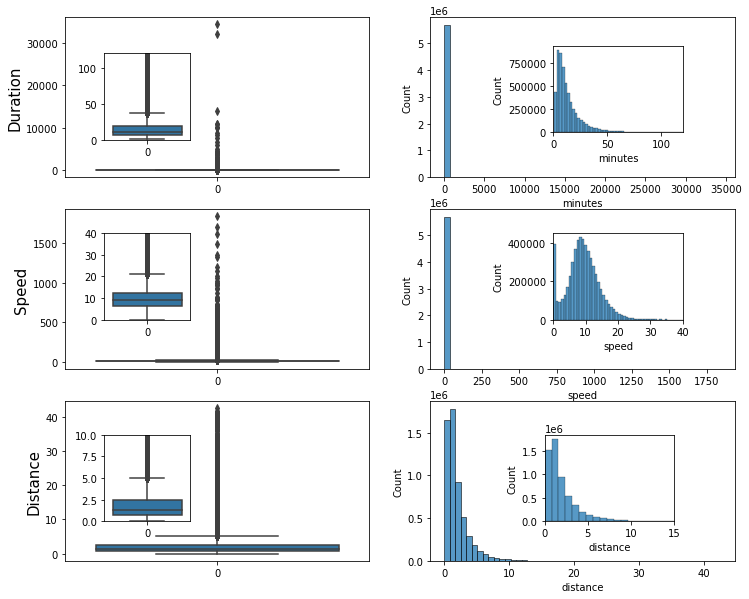

In [65]:
fig, ax = plt.subplots(3, 2)

fig.set_figwidth(12)
fig.set_figheight(10)

### boxplots
sns.boxplot(ax=ax[0, 0], data=rides_with_features["minutes"])
sns.boxplot(ax=ax[1, 0], data=rides_with_features["speed"])
sns.boxplot(ax=ax[2, 0], data=rides_with_features["distance"])

# formatting
ax[0, 0].set_ylabel("Duration", size=15)
ax[1, 0].set_ylabel("Speed", size=15)
ax[2, 0].set_ylabel("Distance", size=15)


## boxplot close ups
ax1 = plt.axes([0.17, 0.71, 0.1, 0.12])
ax2 = plt.axes([0.17, 0.46, 0.1, 0.12])
ax3 = plt.axes([0.17, 0.18, 0.1, 0.12])

# minutes
sns.boxplot(
    ax=ax1, data=rides_with_features[rides_with_features["minutes"] < 120]["minutes"]
)

# speed
sns.boxplot(
    ax=ax2, data=rides_with_features[rides_with_features["speed"] < 40]["speed"]
)

# distance
sns.boxplot(
    ax=ax3, data=rides_with_features[rides_with_features["distance"] < 40]["distance"]
)

# formatting
ax1.set_ylim(0, 120)
ax2.set_ylim(0, 40)
ax3.set_ylim(0, 10)


### histograms
sns.histplot(ax=ax[0, 1], data=rides_with_features["minutes"], bins=50)
sns.histplot(ax=ax[1, 1], data=rides_with_features["speed"], bins=50)
sns.histplot(ax=ax[2, 1], data=rides_with_features["distance"], bins=50)

## histogram close ups
ax4 = plt.axes([0.69, 0.72, 0.15, 0.12])
ax5 = plt.axes([0.69, 0.46, 0.15, 0.12])
ax6 = plt.axes([0.68, 0.18, 0.15, 0.12])

# minutes
sns.histplot(
    ax=ax4,
    data=rides_with_features[rides_with_features["minutes"] < 120]["minutes"],
    bins=50,
)

# speed
sns.histplot(
    ax=ax5,
    data=rides_with_features[rides_with_features["speed"] < 40]["speed"],
    bins=50,
)

# distance
sns.histplot(
    ax=ax6,
    data=rides_with_features[rides_with_features["distance"] < 40]["distance"],
    bins=50,
)

# formatting
ax4.set_xlim(0, 120)
ax5.set_xlim(0, 40)
ax6.set_xlim(0, 15)

Since we are interested in the majority of users, we can trim the data to avoid outliers. The code below shows that by keeping the records that lie within 3 standard deviations from the mean for duration and speed, as well as trips with a length of less than 10 km we would be dropping at most 1.944% of the data (at most because some rows could be outside more than one of these ranges and would count multiple times towards the sum). 

In [66]:
# count number of trips beyond the given maximum value
mins = len(rides_with_features[rides_with_features["minutes"] > 120])
speed = len(rides_with_features[rides_with_features["speed"] > 24])
dist = len(rides_with_features[rides_with_features["distance"] > 10])

# get the percentage (not exacly the % but close) of the trips outside the given ranges
100 * (mins + speed + dist) / len(rides_with_features)

1.9451115187904218

So lets proceed with filtering out those records (I didn't use exacly 3 standard deviations since part of the tails of the histograms were high enough to stil be statistically significant. For the duration variable it was the opposite, so I used less than 3 std)

In [67]:
# filter out the outliers
rides_filtered = rides_with_features[rides_with_features["minutes"] <= 100]
rides_filtered = rides_filtered[rides_filtered["speed"] <= 30]
rides_filtered = rides_filtered[rides_filtered["distance"] <= 10]
del rides_clean

This is how the distributions look after filtering outliers and trimming the data.

Text(0, 0.5, 'Distance')

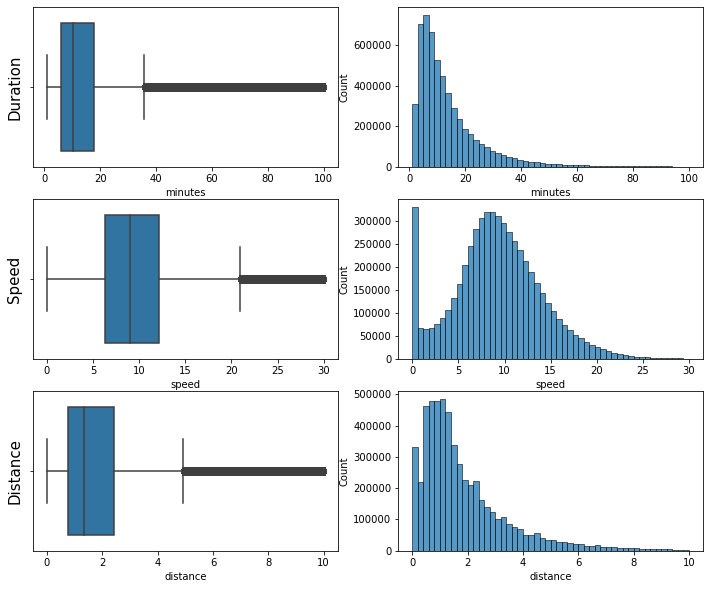

In [68]:
fig, ax = plt.subplots(3, 2)

fig.set_figwidth(12)
fig.set_figheight(10)

## boxplots
sns.boxplot(ax=ax[0, 0], data=rides_filtered, x="minutes")
sns.boxplot(ax=ax[1, 0], data=rides_filtered, x="speed")
sns.boxplot(ax=ax[2, 0], data=rides_filtered, x="distance")

## histograms
sns.histplot(ax=ax[0, 1], data=rides_filtered["minutes"], bins=50)
sns.histplot(ax=ax[1, 1], data=rides_filtered["speed"], bins=50)
sns.histplot(ax=ax[2, 1], data=rides_filtered["distance"], bins=50)

# plot formatting
ax[0, 0].set_ylabel("Duration", size=15)
ax[1, 0].set_ylabel("Speed", size=15)
ax[2, 0].set_ylabel("Distance", size=15)

### Coordinates <a name="start_coords"></a>

For completeness we also take a look at the stations coordinates, both start and end

In [69]:
rides_filtered[["start_lat", "end_lat", "start_lng", "end_lng"]].agg(
    ["mean", "median", "std", "min", "max"]
)

,start_lat,end_lat,start_lng,end_lng
mean,41.902304,41.902532,-87.647846,-87.648026
median,41.900000,41.900000,-87.644107,-87.644336
std,0.045777,0.045944,0.028996,0.029140
min,41.640000,41.600000,-87.840000,-87.920000
max,42.070000,42.130000,-87.520000,-87.500000


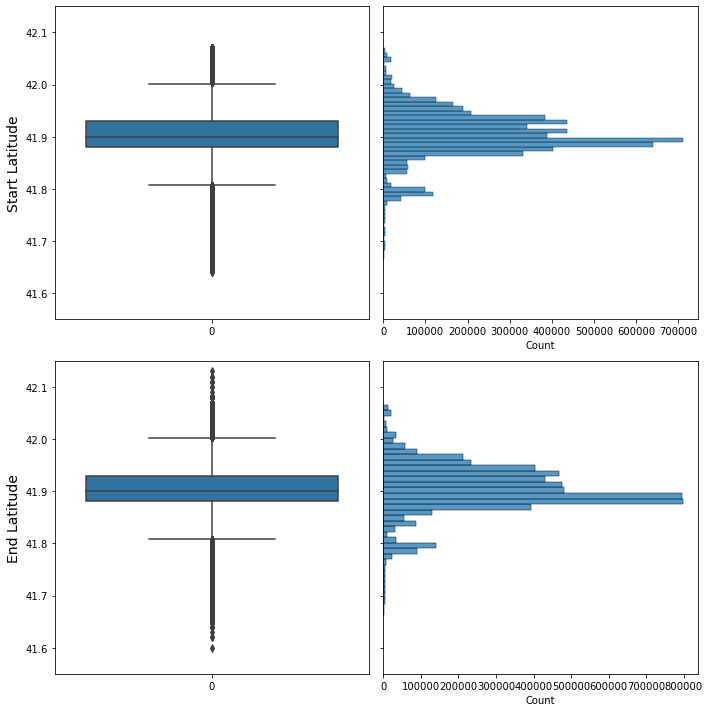

In [70]:
fig, ax = plt.subplots(2, 2, sharey=True)

fig.set_figwidth(10)
fig.set_figheight(10)

# boxplots
sns.boxplot(ax=ax[0, 0], data=rides_filtered["start_lat"])
sns.boxplot(ax=ax[1, 0], data=rides_filtered["end_lat"])

# histograms
sns.histplot(ax=ax[0, 1], data=rides_filtered, y="start_lat", bins=50)
sns.histplot(ax=ax[1, 1], data=rides_filtered, y="end_lat", bins=50)

# formatting
ax[0, 0].set_ylim(41.55, 42.15)
ax[1, 0].set_ylim(41.55, 42.15)
ax[0, 0].set_ylabel("Start Latitude", size=14)
ax[1, 0].set_ylabel("End Latitude", size=14)

plt.tight_layout()

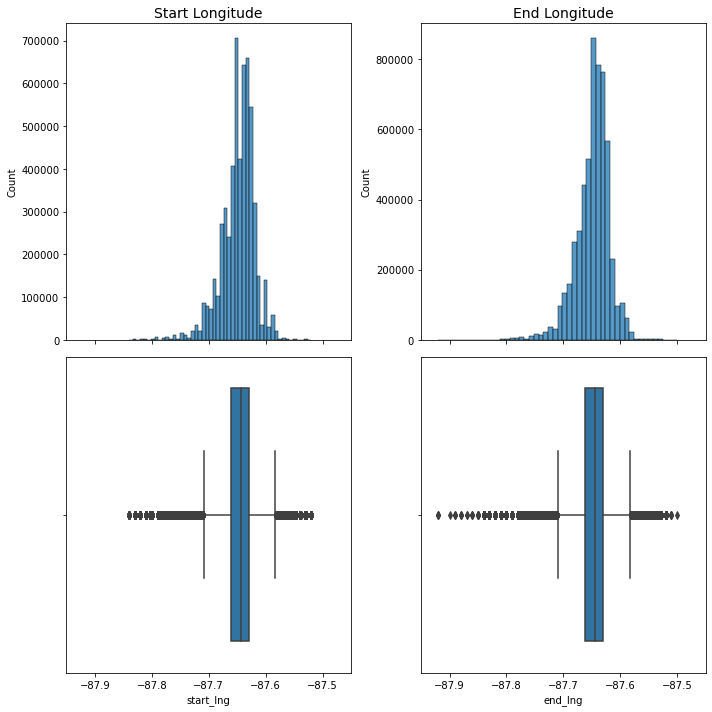

In [71]:
fig, ax = plt.subplots(2, 2, sharex=True)

fig.set_figwidth(10)
fig.set_figheight(10)

# histograms
sns.histplot(ax=ax[0, 0], data=rides_filtered, x="start_lng", bins=50)
sns.histplot(ax=ax[0, 1], data=rides_filtered, x="end_lng", bins=50)

# boxplots
sns.boxplot(ax=ax[1, 0], data=rides_filtered, x="start_lng")
sns.boxplot(ax=ax[1, 1], data=rides_filtered, x="end_lng")

# formatting
ax[1, 0].set_xlim(-87.95, -87.45)
ax[1, 1].set_xlim(-87.95, -87.45)
ax[0, 0].set_title("Start Longitude", size=14)
ax[0, 1].set_title("End Longitude", size=14)

plt.tight_layout()

The range for the end station coordinates is larger than that of the start station's, and there are more evident outliers, especially for the longitude. To keep things simple we can restrict the range of coordinates to be that of the start stations.

In [72]:
# define ranges
min_lat = rides_filtered["start_lat"].min()
max_lat = rides_filtered["start_lat"].max()
min_lng = rides_filtered["start_lng"].min()
max_lng = rides_filtered["start_lng"].max()

# filter by the ranges defined
rides_filtered = rides_filtered[
    (rides_filtered["end_lat"] >= min_lat) & (rides_filtered["end_lat"] <= max_lat)
]
rides_filtered = rides_filtered[
    (rides_filtered["end_lng"] >= min_lng) & (rides_filtered["end_lng"] <= max_lng)
]

# Verification <a name="verification"></a>

Now that we have a final cleaned version of the data it is a good time to verify that everything makes sense: there should be no missing values, the number of unique values for each field should be correct, and the ranges for the numeric variables should be within reason.

The number of missing values is

In [73]:
rides_filtered.isnull().sum().sum()

0

As for the number of unique values, 
* the number of bike types is 3 and number of user types 2, as should be
* start names and id's are a little bit high but, as mentioned earlier, this would need further clarification with the company
* the number of start and end coordinates are reasonable for the number of stations + the electric bikes that need not be parked at any given station
* there are 2 years, 12 months, 24 hours and 365 days in the last year.

In [74]:
rides_filtered.nunique()

trip_id        5590170
bike_type            3
start_time     4724002
end_time       4736340
start_name        1285
start_id          1285
end_name          1287
end_id            1287
start_lat          778
start_lng          801
end_lat            756
end_lng            754
usertype             2
year                 2
month               12
time_of_day         24
date               365
duration          5944
minutes            991
day_of_week          7
distance        236434
speed             3001
dtype: int64

As for the numeric fields, all ranges look good.

In [75]:
rides_filtered.columns

Index(['trip_id', 'bike_type', 'start_time', 'end_time', 'start_name',
       'start_id', 'end_name', 'end_id', 'start_lat', 'start_lng', 'end_lat',
       'end_lng', 'usertype', 'year', 'month', 'time_of_day', 'date',
       'duration', 'minutes', 'day_of_week', 'distance', 'speed'],
      dtype='object')

In [76]:
rides_filtered[
    [
        "start_lat",
        "start_lng",
        "end_lat",
        "end_lng",
        "year",
        "time_of_day",
        "duration",
        "minutes",
        "distance",
        "speed",
    ]
].agg(["min", "max", "mean"])

,start_lat,start_lng,end_lat,end_lng,year,time_of_day,duration,minutes,distance,speed
min,41.640000,-87.840000,41.640000,-87.840000,2022.000000,0.000000,0 days 00:01:00,1.000000,0.000000,0.000000
max,42.070000,-87.520000,42.070000,-87.520000,2023.000000,23.000000,0 days 01:40:03,100.000000,9.999998,30.000000
mean,41.902303,-87.647845,41.902531,-87.648025,2022.065202,14.213953,0 days 00:14:23.470401615,14.391231,1.852310,9.181801


Now that everything is filtered, consistent and clean we can clear up things a bit and go back the original datafrane name, just because.

In [78]:
rides = rides_filtered.copy()

After all these steps, as can be seen below, in total we lost %4.098 of the data during cleaning. That's not too bad. 

In [79]:
(all_data.shape[0] - rides.shape[0]) / all_data.shape[0] * 100

4.098654265404307

Lets clear the dataframes that won't be used anymore

In [80]:
del  all_data, rides_with_features, rides_filtered

And, finally, we need to save the data for analysis.

In [81]:
rides.to_csv("../data/cleaned/rides.csv", index=False)